# Improving Trajectory Classification through Kramers Moyal Coefficients

### G. Viera-López, J.J. Morgado-Vega, A. Reyes, E. Altshuler, Yudivián Almeida-Cruz, Giorgio Manganini

Code base to reproduce the results of the manuscript, currently under review in AI Open

## 1. Initialization:

Make sure you are running this notebook with a python 3.9+ kernel.

### 1.1 Installing software dependencies:

The experimentation was conducted using the **pactus** framework for trajectory classification. In addition, we use the library **kramersmoyal** for the calculation of the Kramers Moyal Coefficients. Both can be installed from pypi by running:

In [1]:
%pip install pactus kramersmoyal

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**Pactus** will also install **yupi**, a python library to process trajectory data.

### 1.2 Importing required dependencies:

In [2]:
import os
import warnings
from collections import defaultdict
from pathlib import Path

import kramersmoyal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from pactus import Dataset, featurizers
from pactus.models import DecisionTreeModel, Evaluation, RandomForestModel, XGBoostModel
from pactus.models.model import Model
from yupi import Trajectory


2024-02-06 19:09:05.120392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 19:09:05.160973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 19:09:05.161791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 19:09:06.071874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1.3 Configure variables to ensure repetitibility:

In [3]:
SEED = 0  # Fixed random seed
np.random.seed(SEED)

## 2. Creating feature vectors from trajectories

Since **pactus** has already defined a *featurizer* as a resource to allow mapping arbitrary-sized trajectories into fixed-sized feature vectors, we are going to create our own *featurizer* to use the Kramers Moyal coefficients:

In [4]:
class KramersMoyalFeaturizer(featurizers.Featurizer):
    def __init__(
        self,
        dim: int,
        bins: int = 10,
        cutoff: int = 0,
        bandwidth: float = 0.1,
        powers=None,
    ):
        super().__init__()
        self.dim = dim
        self.bins = np.repeat(bins, dim)
        self.cutoff = cutoff
        self.powers = self._all_tuples(dim) if powers is None else powers
        self.bandwidth = bandwidth

    def _all_tuples(self, size=1):
        if size == 1:
            return [(i,) for i in range(self.dim + 1)]

        prev_tuples = self._all_tuples(size - 1)
        tuples = []
        for prev_t in prev_tuples:
            tuples += [(*prev_t, i) for i in range(self.dim + 1)]
        return tuples

    def featurize(self, trajs: list[Trajectory]) -> np.ndarray:
        feature_vector = []
        for traj in trajs:
            feature_vector.append(self._featurize(traj))
        return np.array(feature_vector)

    @property
    def count(self):
        return len(self.powers) * self.bins[0] * self.bins[1]

    def _featurize(self, traj: Trajectory) -> np.ndarray:
        kmc, _ = kramersmoyal.km(
            traj.v, bins=self.bins, powers=self.powers, bw=self.bandwidth
        )
        if self.cutoff:
            kmc = kmc[:, self.cutoff : -self.cutoff, self.cutoff : -self.cutoff]
        return kmc.reshape(-1)

Moreover, we are going to extend the more general featurizer from **pactus** to also include the features from the Kramers Moyal featurizers.

In [5]:
class UniversalWithKramersMoyalFeaturizer(featurizers.CompoundFeaturizer):
    def __init__(
        self,
        dim: int,
        bins: int = 10,
        cutoff: int = 0,
        bandwidth: float = 0.1,
        powers=None,
    ):
        super().__init__(
            featurizers.UniversalFeaturizer(),
            KramersMoyalFeaturizer(
                dim=dim, bins=bins, cutoff=cutoff, bandwidth=bandwidth, powers=powers
            ),
        )

In the future, we plan to extend pactus codebase to support these featurizers natively.

## 3. Create a function to evaluate a model on a given dataset

With this function we ensure to split the dataset 70/30 for train/test respectively on every dataset, but on MNIST Stroke, where we use the original split provided (60 000 trajectories for training, 10 000 for testing).

In [6]:
def evaluate(model: Model, dataset: Dataset, feat_type: str):
    # Check if the evaluation has already been done
    file_name = f"evaluations/{dataset.name}-{model.name}-{feat_type}-ev.json"
    if os.path.exists(file_name):
        print(f"Aleady evaluated: {file_name}")
        return

    # Preprocess the dataset and split it into train and test sets
    if dataset.name == "mnist_stroke":
        train, test = dataset.cut(60_000)
    else:
        train, test = dataset.split(train_size=0.7, random_state=SEED)

    # Train the model
    model.train(data=train, cross_validation=5)

    # Evaluate the model on a test dataset
    evaluation = model.evaluate(test)

    # Show the evaluation results
    evaluation._show_general_stats()
    evaluation.save(file_name)

## 4. Generating and loading the datasets

### 4.1 Diffusion dataset

In [7]:
def diffusion_trajs(T, dim, dt, N, gamma, sigma, seed=0):
    np.random.seed(seed)
    n = int(T / dt)
    shape = (n, dim, N)
    v = np.zeros(shape)
    dW = np.random.normal(scale=np.sqrt(dt), size=shape)

    for i in range(n - 1):
        v[i + 1] = v[i] - gamma(v[i]) * dt + sigma(v[i]) * dW[i]

    r = v.cumsum(0) * dt
    r -= r[0]
    trajs = [Trajectory(points=r[..., i], dt=dt) for i in range(N)]
    return trajs


def DiffiusionDataset():
    T, dim, dt, N = 50, 2, 0.005, 500
    gamma1 = lambda v: np.array([[2], [1]]) * v
    gamma2 = lambda v: np.array([[1], [2]]) * v
    gamma3 = lambda v: np.array([[1], [1]]) * v
    gamma4 = lambda v: np.array([[2], [2]]) * v
    sigma = lambda v: np.diag([0.1, 0.1]) @ np.ones_like(v)
    trajs1 = diffusion_trajs(T, dim, dt, N, gamma1, sigma)
    trajs2 = diffusion_trajs(T, dim, dt, N, gamma2, sigma)
    trajs3 = diffusion_trajs(T, dim, dt, N, gamma3, sigma)
    trajs4 = diffusion_trajs(T, dim, dt, N, gamma4, sigma)

    labels1 = [1] * len(trajs1)
    labels2 = [2] * len(trajs2)
    labels3 = [3] * len(trajs3)
    labels4 = [4] * len(trajs4)
    return Dataset(
        "diffusion",
        trajs1 + trajs2 + trajs3 + trajs4,
        labels1 + labels2 + labels3 + labels4,
    )

### 4.2 Data cleaning on the benchmark datasets

In [8]:
# Remove short and static trajectories from the GeoLife dataset
hurdat2 = Dataset.hurdat2()
hurdat2_data = hurdat2.filter(
    lambda t, _: len(t) > 5 and not all([v == 0 for v in t.v.reshape(-1)])
)

# Remove short and poorly time sampled trajectories and classes with few
# trajectories from the GeoLife dataset
geolife = Dataset.geolife()
geolife_data = geolife.filter(lambda traj, _: len(traj) > 10 and traj.dt < 8)
geolife_data = geolife.filter(lambda _, label: geolife_data.label_counts[label] > 5)

# Remove short trajectories and classes with only one trajectory from the CMA
# Typhoon dataset
cma = Dataset.cma_bst()
cma_data = cma.filter(lambda traj, label: len(traj) > 5 and cma.label_counts[label] > 1)

19:09:08 [INFO] Filtered 1872 of 1903 trajectories
19:09:11 [INFO] Filtered 7630 of 9288 trajectories
19:09:11 [INFO] Filtered 9261 of 9288 trajectories
19:09:11 [INFO] Filtered 2340 of 2360 trajectories


### 4.3 Gathering all the datasets

In [9]:
diffusion_datset = DiffiusionDataset()
benchmark_datasets = [
    Dataset(geolife.name, geolife_data.trajs, geolife_data.labels),
    Dataset.animals(),
    Dataset(hurdat2.name, hurdat2_data.trajs, hurdat2_data.labels),
    Dataset(cma.name, cma_data.trajs, cma_data.labels),
    Dataset.mnist_stroke(),
    Dataset.uci_pen_digits(),
    Dataset.uci_characters(),
    Dataset.uci_movement_libras(),
]

## 5. Loading all the classification models

Here we define a function to return all three classification models for a given *featurizer*:

In [10]:
def get_models(featurizer, num_classes: int):
    return [
        XGBoostModel(
            featurizer=featurizer,
            n_estimators=200,
            n_jobs=6,
            objective="multi:softprob" if num_classes > 2 else "binary:logistic",
            random_state=SEED,
        ),
        RandomForestModel(
            featurizer=featurizer,
            max_features=16,
            n_estimators=200,
            bootstrap=False,
            warm_start=True,
            n_jobs=6,
            random_state=SEED,
        ),
        DecisionTreeModel(
            featurizer=featurizer,
            max_depth=7,
            random_state=SEED,
        ),
    ]

## 6. Running all the experiments

### 6.1 Evaluation of different configurations of Kramers Moyal featurizers

Since the Kramers Moyal featurizers can be customized with the *bins* hyperparameter, we created a range of *bins* values to be evaluated.

In [11]:
bins_vals = list(range(1, 10))

### 6.2 Evaluating all three models for every dataset and for every featurizer

In [12]:
for bins_val in bins_vals:
    unkm_featurizer = KramersMoyalFeaturizer(2, bins=bins_val)
    for model in get_models(unkm_featurizer, len(diffusion_datset.classes)):
        evaluate(model, diffusion_datset, f"onlykm-{bins_val}")

for ds in [diffusion_datset] + benchmark_datasets:
    # Evaluate the classical featurizer
    univ_featurizer = featurizers.UniversalFeaturizer()

    for model in get_models(univ_featurizer, len(ds.classes)):
        evaluate(model, ds, "univ")

    for bins_val in bins_vals:
        unkm_featurizer = UniversalWithKramersMoyalFeaturizer(2, bins=bins_val)
        for model in get_models(unkm_featurizer, len(ds.classes)):
            evaluate(model, ds, f"km-{bins_val}")

Aleady evaluated: evaluations/diffusion-xgboost-onlykm-1-ev.json
Aleady evaluated: evaluations/diffusion-random_forest-onlykm-1-ev.json
Aleady evaluated: evaluations/diffusion-decision_tree-onlykm-1-ev.json
Aleady evaluated: evaluations/diffusion-xgboost-onlykm-2-ev.json
Aleady evaluated: evaluations/diffusion-random_forest-onlykm-2-ev.json
Aleady evaluated: evaluations/diffusion-decision_tree-onlykm-2-ev.json
Aleady evaluated: evaluations/diffusion-xgboost-onlykm-3-ev.json
Aleady evaluated: evaluations/diffusion-random_forest-onlykm-3-ev.json
Aleady evaluated: evaluations/diffusion-decision_tree-onlykm-3-ev.json
Aleady evaluated: evaluations/diffusion-xgboost-onlykm-4-ev.json
Aleady evaluated: evaluations/diffusion-random_forest-onlykm-4-ev.json
Aleady evaluated: evaluations/diffusion-decision_tree-onlykm-4-ev.json
Aleady evaluated: evaluations/diffusion-xgboost-onlykm-5-ev.json
Aleady evaluated: evaluations/diffusion-random_forest-onlykm-5-ev.json
Aleady evaluated: evaluations/diffus

### 6.3 Load evaluation files

In [13]:
univ_evals = {}
km_evals = {}
onlykm_evals = {}

for eval_file in Path("evaluations").iterdir():
    splitted = eval_file.name.split("-")
    ds_name, model_name, feat_type = splitted[0], splitted[1], splitted[2]
    if feat_type == "km":
        bins = int(splitted[3])
        models_dict = km_evals.get(ds_name, {})
        bins_dict = models_dict.get(model_name, {})
        bins_dict[bins] = Evaluation.load(str(eval_file))
        models_dict[model_name] = bins_dict
        km_evals[ds_name] = models_dict
    elif feat_type == "onlykm":
        bins = int(splitted[3])
        models_dict = onlykm_evals.get(ds_name, {})
        bins_dict = models_dict.get(model_name, {})
        bins_dict[bins] = Evaluation.load(str(eval_file))
        models_dict[model_name] = bins_dict
        onlykm_evals[ds_name] = models_dict
    elif feat_type == "univ":
        models_dict = univ_evals.get(ds_name, {})
        models_dict[model_name] = Evaluation.load(str(eval_file))
        univ_evals[ds_name] = models_dict
    else:
        raise Exception("Invalid eval file")

### 6.4 Evaluation results of the diffusion dataset

Now we analyse the test results on the accuracy and macro averaged F1 score for the *diffiusion* dataset for all the featurizers (and all bins) used in the training of the 3 models. These results are shown in Table 1 of the manuscript.

In [14]:
print("Universal Featurizer on diffusion dataset\n")
print(f"{'Model':<15} {'Acc':>10} {'F1':>10}")
for model, eval in univ_evals[diffusion_datset.name].items():
    print(f"{model:<15} {eval.acc_overall:>10.2%} {eval.f1_score:>10.2%}")

print("\nOnly Kramers-Moyal Featurizer on diffusion dataset\n")
for model in onlykm_evals[diffusion_datset.name]:
    print(f"\nModel: {model}\n")
    print(f"{'Bins':<5} {'Acc':>10} {'F1':>10}")
    for bins_val, eval in sorted(
        onlykm_evals[diffusion_datset.name][model].items(), key=lambda x: x[0]
    ):
        print(f"{bins_val:<5} {eval.acc_overall:>10.2%} {eval.f1_score:>10.2%}")

print("\nUniversal + Kramers-Moyal Featurizer on diffusion dataset\n")
for model in km_evals[diffusion_datset.name]:
    print(f"\nModel: {model}\n")
    print(f"{'Bins':<5} {'Acc':>10} {'F1':>10}")
    for bins_val, eval in sorted(
        km_evals[diffusion_datset.name][model].items(), key=lambda x: x[0]
    ):
        print(f"{bins_val:<5} {eval.acc_overall:>10.2%} {eval.f1_score:>10.2%}")

Universal Featurizer on diffusion dataset

Model                  Acc         F1
xgboost             61.00%     60.88%
random_forest       63.00%     62.65%
decision_tree       58.33%     57.74%

Only Kramers-Moyal Featurizer on diffusion dataset


Model: xgboost

Bins         Acc         F1
1          7.83%      7.83%
2         70.83%     70.84%
3         78.33%     78.31%
4         86.33%     86.33%
5         84.83%     84.84%
6         78.83%     78.62%
7         66.33%     66.31%
8         79.00%     79.00%
9         86.50%     86.51%

Model: random_forest

Bins         Acc         F1
1         21.67%     21.66%
2         71.83%     71.86%
3         73.83%     73.83%
4         85.17%     85.18%
5         87.00%     87.00%
6         70.50%     69.85%
7         65.50%     65.56%
8         78.50%     78.51%
9         85.17%     85.18%

Model: decision_tree

Bins         Acc         F1
1         31.00%     29.39%
2         59.00%     58.97%
3         65.33%     65.35%
4         70.33% 

### 6.5 Evaluation results on the benchmark datasets

In [15]:
def get_data_for_comparing(metric_func=None) -> tuple[dict, dict]:
    """
    Takes all the evaluations and a given metric and returns the value of that
    metric using the universal featurizer and the propoused featurizer. In the
    last case, it also stores the best bin hyperparameter value.
    """
    univ_data = defaultdict(dict)
    km_data = defaultdict(dict)

    def _metric(ev):
        return ev.acc_overall if metric_func is None else metric_func(ev)

    def metric(*evals):
        idx = 0
        max_val = _metric(evals[0])
        for i, ev in enumerate(evals):
            current = _metric(ev)
            if current > max_val:
                idx = i
                max_val = current
        return idx, max_val

    for ds_name, models_dict in univ_evals.items():
        for model_name, ev in models_dict.items():
            univ_data[ds_name][model_name] = dict(val=metric(*[ev])[1])

    for ds_name, models_dict in km_evals.items():
        for model_name, bins_dict in models_dict.items():
            bins = list(bins_dict.keys())
            evals = list(bins_dict.values())
            idx, max_val = metric(*evals)
            km_data[ds_name][model_name] = dict(best_bin=bins[idx], val=max_val)

    return univ_data, km_data


def print_results_table(univ_data, km_data):
    """
    Takes two evaluation datas and prints the comparison results for each model.
    """
    models_data = defaultdict(dict)
    for ds_name, model_ev in univ_data.items():
        for model_name, univ_ev in model_ev.items():
            univ_val = univ_ev["val"]
            km_val = km_data[ds_name][model_name]["val"]
            models_data[model_name][ds_name] = (univ_val, km_val)

    for model_name, ds_data in models_data.items():
        print(f"\nModel: {model_name}\n")
        print(f"{'Dataset':<25} {'Univ %':>10} {'KM %':>10}")
        for ds_name, data in ds_data.items():
            univ_val = data[0] * 100
            km_val = data[1] * 100
            print(f"{ds_name:<25} {univ_val:>10.2f} {km_val:>10.2f}")
        print()

### 6.6 Get the accuracy and the macro avergaed F1 score

In [16]:
univ_acc_data, km_acc_data = get_data_for_comparing(lambda ev: ev.acc_overall)
univ_f1_data, km_f1_data = get_data_for_comparing(lambda ev: ev.f1_score)

### 6.7 Accuracy table

Show the accuracy obteined when using each feature vector for each model with all the datasets. These results are shown in Table 2 of the manuscript.

In [17]:
print("Accuracy")
print_results_table(univ_acc_data, km_acc_data)

Accuracy

Model: random_forest

Dataset                       Univ %       KM %
uci_movement_libras            67.89      88.07
hurdat2                        51.78      53.02
uci_pen_digits                 96.54      98.67
cma_bst                        48.58      50.14
animals                        94.74      97.37
geolife                        87.12      87.23
diffusion                      63.00      87.17
mnist_stroke                   86.97      93.14
uci_characters                 99.07      99.88


Model: decision_tree

Dataset                       Univ %       KM %
uci_movement_libras            57.80      66.97
hurdat2                        43.77      50.71
uci_pen_digits                 76.99      83.32
cma_bst                        42.45      47.72
animals                        84.21      84.21
geolife                        81.14      81.43
diffusion                      58.33      78.17
mnist_stroke                   71.59      78.90
uci_characters                 8

### 6.8 Macro averaged F1 score table

Show the macro averaged F1 score obteined when using each feature vector for each model with all the datasets. These results are shown in Table 3 of the manuscript.

In [18]:
print("F1 score")
print_results_table(univ_f1_data, km_f1_data)

F1 score

Model: random_forest

Dataset                       Univ %       KM %
uci_movement_libras            63.50      87.36
hurdat2                        30.55      31.93
uci_pen_digits                 96.57      98.67
cma_bst                        36.84      38.53
animals                        92.81      96.46
geolife                        81.25      81.29
diffusion                      62.65      87.15
mnist_stroke                   86.85      93.09
uci_characters                 98.98      99.87


Model: decision_tree

Dataset                       Univ %       KM %
uci_movement_libras            56.58      66.42
hurdat2                        23.34      32.34
uci_pen_digits                 77.34      83.83
cma_bst                        33.34      34.75
animals                        81.82      80.79
geolife                        70.45      70.55
diffusion                      57.74      78.28
mnist_stroke                   71.40      78.76
uci_characters                 7

### 6.9 Mean increase in accuracy and F1 score

In [19]:
def get_model_deltas(univ_data, km_data):
    deltas = defaultdict(list)
    for ds_name, models_ev in univ_data.items():
        for model_name, univ_ev in models_ev.items():
            univ_val = univ_ev["val"]
            km_val = km_data[ds_name][model_name]["val"]
            deltas[model_name].append(km_val - univ_val)
    return deltas


delta_acc = get_model_deltas(univ_acc_data, km_acc_data)
delta_f1 = get_model_deltas(univ_f1_data, km_f1_data)

print("Mean increase in accuracy for each model:")
for model, deltas in delta_acc.items():
    print(f"{model:<15} {np.mean(np.array(deltas) * 100):>6.2f}%")

print("\nMean increase in macro average F1 score for each model:")
for model, deltas in delta_f1.items():
    print(f"{model:<15} {np.mean(np.array(deltas) * 100):>6.2f}%")

Mean increase in accuracy for each model:
random_forest     6.56%
decision_tree     6.13%
xgboost           6.48%

Mean increase in macro average F1 score for each model:
random_forest     7.15%
decision_tree     5.97%
xgboost           6.70%


## 7. Statistical analysis

Let us extract the accuracy and f1 score obtained with both the Universal and Universal + KMC featurizers for all datasets

In [20]:
ac = np.array([
    [models["xgboost"]["val"], km_acc_data[ds]["xgboost"]["val"],
    models["random_forest"]["val"], km_acc_data[ds]["random_forest"]["val"],
    models["decision_tree"]["val"], km_acc_data[ds]["decision_tree"]["val"]]
    for ds, models
    in univ_acc_data.items() if ds != "diffusion"
]) * 100

f1 = np.array([
    [models["xgboost"]["val"], km_f1_data[ds]["xgboost"]["val"],
    models["random_forest"]["val"], km_f1_data[ds]["random_forest"]["val"],
    models["decision_tree"]["val"], km_f1_data[ds]["decision_tree"]["val"]]
    for ds, models
    in univ_f1_data.items() if ds != "diffusion"
]) * 100

A Wilcoxon signed-rank test was employed to evaluate the difference in performance between the two feature vectors. The p-values of the tests are all less than the significance level, indicating a consistent superiority of $\mathbf{\hat{V}_B}$ over $\mathbf{V}$.

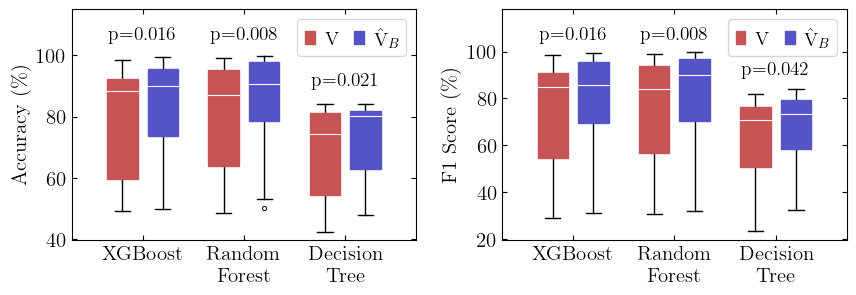

In [21]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

w = .2
center = np.arange(3)
x = np.hstack(np.vstack([center - w, center + w]).T)

fs = 15
colors = ['#c65454', '#5454c6']
xlabels = ['XGBoost', 'Random\nForest', 'Decision\nTree']
yp = [105, 105, 90]
fig, axs = plt.subplots(1, 2, figsize=(10,3))
for i, data in enumerate([ac, f1]):
    bp = axs[i].boxplot(data, positions=x, widths=.3, patch_artist=True)

    pvalue = []
    for k in [0,2,4]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            test = scipy.stats.wilcoxon(*data[:,k:k+2].T, zero_method='zsplit')
        pvalue.append(test.pvalue)
    for c in center:
        axs[i].text(center[c], yp[c], f'p={pvalue[c]:.3f}', ha='center', fontsize=fs-1)

    axs[i].tick_params(direction='in', top=True, right=True, labelsize=fs)
    axs[i].set_ylabel(['Accuracy (\%)', 'F1 Score (\%)'][i], fontsize=fs)
    axs[i].set_xticks(center, labels=xlabels)
    axs[i].set_ylim(None, [115,118][i])
    for j, patch in enumerate(bp['boxes']):
        patch.set(facecolor=colors[j%2], color=colors[j%2])
    plt.setp(bp['medians'], color='w', lw=.8)
    plt.setp(bp['whiskers'], zorder=0)
    plt.setp(bp['fliers'], ms=3, mew=.7)
    axs[i].legend(
        [bp['boxes'][0], bp['boxes'][1]], ['$\mathrm{V}$', '$\hat\mathrm{V}_B$'], 
        loc='upper right', handlelength=.5, handletextpad=.5, 
        ncol=2, columnspacing=0.8, fontsize=fs-1)

plt.subplots_adjust(wspace=.25)
plt.show()